# Greedily construct the MA ppln that preserves the most song information in its firing rate

Because each neuron maps song to a single real number, $r_i = f_i[s(t < t')]$, the mutual info $MI[r_i, s]$ is given simply by the response entropy $H[r_i]$, since

$$MI[r_i, s] = H[r_i] - E_s[H[r_i|s]] = H[r_i]$$

since $H[r_i|s] = H[f_i(s)|s] = 0$, i.e. there is no noise, so each song maps to exactly one neural response value.

In [1]:
%matplotlib inline
from itertools import product as cproduct
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import sys

from disp import set_plot


cc = np.concatenate

FPS = 30.03  # sampling rate of behavioral data
DT = 1/FPS

STRAINS = ['NM91', 'ZH23']
STRAIN_KEY = '_'.join(STRAINS).lower()

FSTRAIN = 'data/simple/strains.csv'
MSTRAINS = [(pd.read_csv(FSTRAIN)['STRAIN'] == strain) for strain in STRAINS]
MSTRAIN = np.any(MSTRAINS, axis=0)
ISTRAIN = MSTRAIN.nonzero()[0]

In [2]:
# neural params
TAU_R = np.array([.1, .5, 1, 2, 5, 10, 30, 60, 120])
TAU_A = np.array([.1, .5, 1, 2, 5, 10, 30, 60, np.inf])
X_S = np.array([0, .5, 1])

tau_r_tau_a_x_s = np.array(list(cproduct(TAU_R, TAU_A, X_S)))

tau_rs = tau_r_tau_a_x_s[:, 0]
tau_as = tau_r_tau_a_x_s[:, 1]
x_ss = tau_r_tau_a_x_s[:, 2]
x_ps = 1 - x_ss  # pulse selectivity

nr = len(tau_rs)

In [3]:
# load all neural recordings
PFX_NRL = f'data/simple/mlv/ma_red_greedy/nrl/ma_red_greedy_nrl'

dfs_tr = [np.load(f'{PFX_NRL}_tr_{itr}.npy', allow_pickle=True)[0]['df'] for itr in ISTRAIN]

In [4]:
R_COLS = [f'R_{ir}' for ir in range(nr)]

# keep all neural activity
# frs = cc([np.array(df_tr[R_COLS]) for df_tr in dfs_tr])

# only keep neural activity after first song onset
it_song_starts = [np.nonzero(np.array(df_tr['Q']) == 0)[0][0] for df_tr in dfs_tr]
frs = cc([np.array(df_tr[R_COLS])[it_song_start:, :] for df_tr, it_song_start in zip(dfs_tr, it_song_starts)])

dfs_tr = None

In [20]:
nnrn = 8
ents = -1 * np.ones((nnrn, nr))

nbin = 10
bins = np.linspace(0, 1, nbin+1)

frs_prev = np.nan*np.zeros((0, len(frs)))

for cnrn in range(nnrn):
    sys.stdout.write('\n>')
    
    frs_next = None
    
    for inrn in range(frs.shape[1]):
        sys.stdout.write('.')
        
        fr_new = frs[:, inrn].copy()
        fr_new /= fr_new.max()
    
        frs_cand = cc([frs_prev, fr_new[None, :]], axis=0)
        
        cts_fr = np.histogramdd(frs_cand.T, bins=(cnrn+1)*[bins])[0]
        p_fr = cts_fr/cts_fr.sum()
        
        ent = stats.entropy(p_fr.flatten(), base=2)
        ents[cnrn, inrn] = ent
        
        if np.all(ent >= ents[cnrn, :]):
            frs_next = frs_cand
        
    frs_prev = frs_next.copy()


>...................................................................................................................................................................................................................................................
>...................................................................................................................................................................................................................................................
>...................................................................................................................................................................................................................................................
>...................................................................................................................................................................................................................................................
>..................

KeyboardInterrupt: 

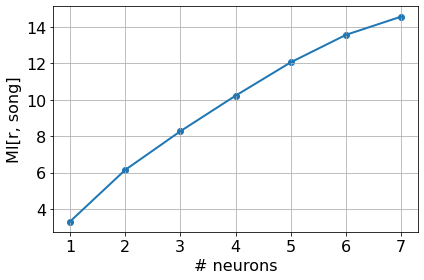

In [73]:
# plot max entropies vs number neurons
ents_max = ents.max(axis=1)
# ents_max = ents[np.arange(nnrn, dtype=int), np.arange(nnrn, dtype=int)]
ents_max[ents_max <= 0] = np.nan

fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=True)
ax.plot(1+np.arange(nnrn), ents_max, lw=2)
ax.scatter(1+np.arange(nnrn), ents_max)
ax.grid()
set_plot(ax, x_label='# neurons', y_label='MI[r, song]', font_size=16)

In [74]:
# print top neurons
for cnrn in range(nnrn):
    inrn_best = ents[cnrn, :].argmax()
    print(f'Neuron {inrn_best}')
    print(f'X_S = {x_ss[inrn_best]}, X_P = {1-x_ss[inrn_best]}')
    print(f'TAU_R = {tau_rs[inrn_best]}, TAU_A = {tau_as[inrn_best]}')
    print()

Neuron 206
X_S = 1.0, X_P = 0.0
TAU_R = 60.0, TAU_A = 10.0

Neuron 91
X_S = 0.5, X_P = 0.5
TAU_R = 2.0, TAU_A = 2.0

Neuron 216
X_S = 0.0, X_P = 1.0
TAU_R = 120.0, TAU_A = 0.1

Neuron 57
X_S = 0.0, X_P = 1.0
TAU_R = 1.0, TAU_A = 0.5

Neuron 153
X_S = 0.0, X_P = 1.0
TAU_R = 10.0, TAU_A = 30.0

Neuron 149
X_S = 1.0, X_P = 0.0
TAU_R = 10.0, TAU_A = 5.0

Neuron 135
X_S = 0.0, X_P = 1.0
TAU_R = 10.0, TAU_A = 0.1

Neuron 0
X_S = 0.0, X_P = 1.0
TAU_R = 0.1, TAU_A = 0.1



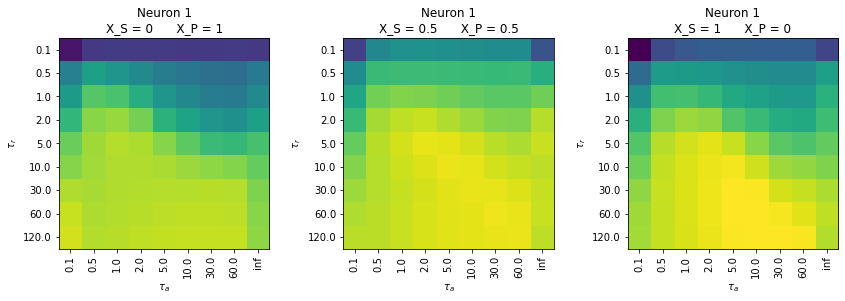

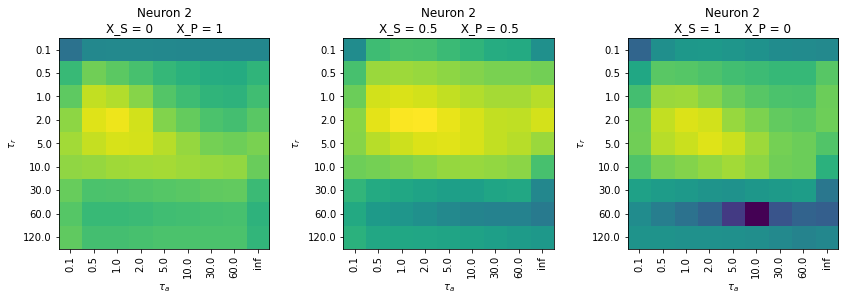

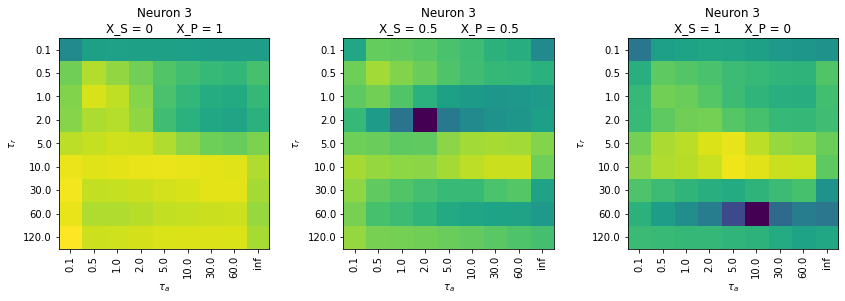

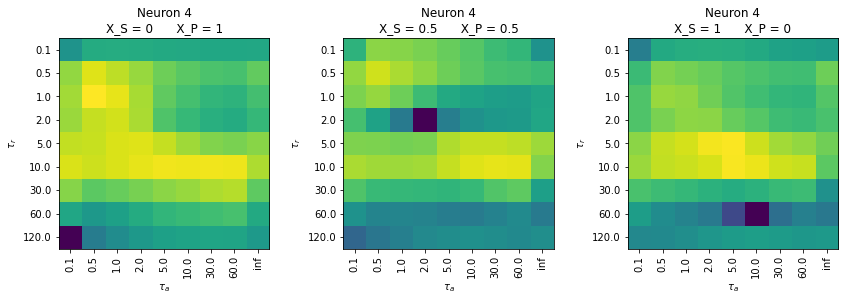

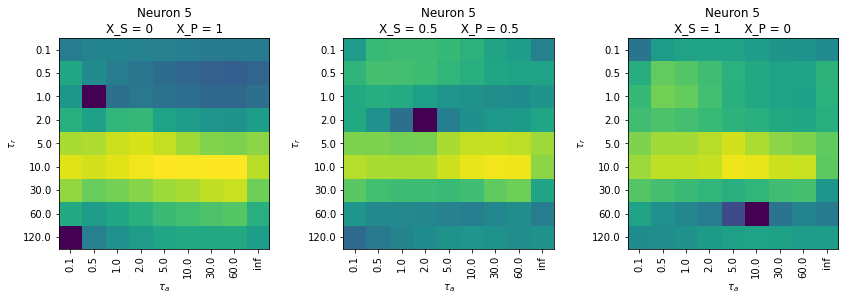

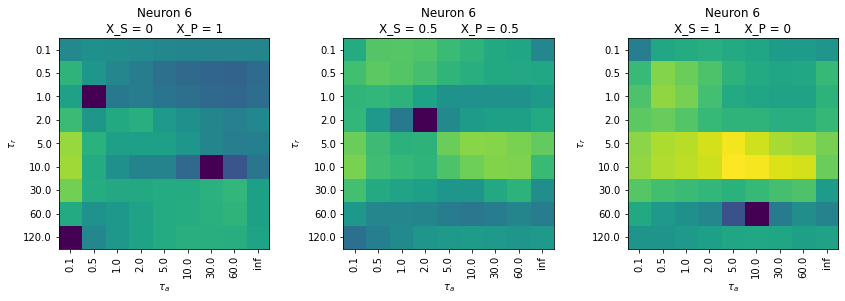

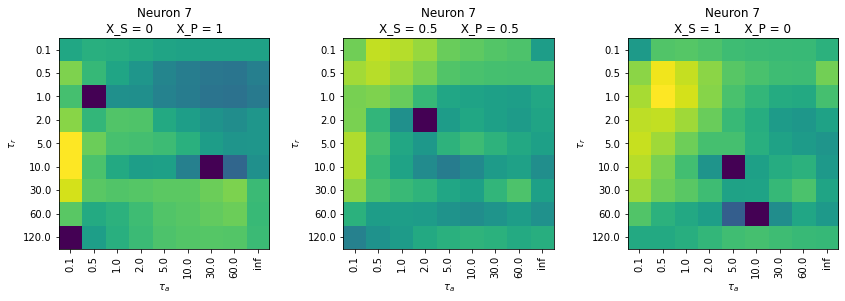

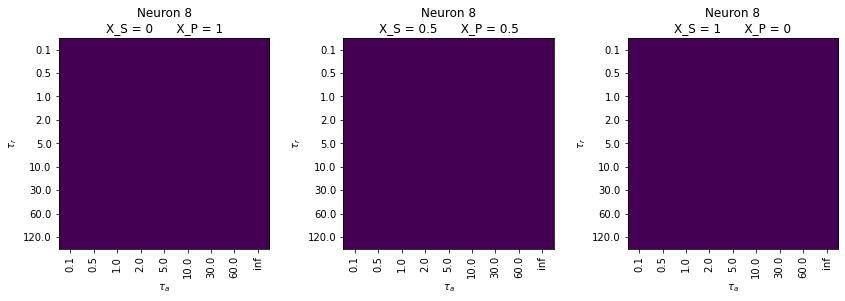

In [75]:
# plot information contributions vs neuron params for greedily added neurons
for cnrn in range(nnrn):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)
    for ax, x_s in zip(axs, [0, .5, 1]):
        mx_s = np.isclose(x_ss, x_s)
        
        ents_x_s = ents[cnrn, mx_s].reshape((len(TAU_R), len(TAU_A)))
        
        ax.matshow(ents_x_s, vmax=ents[cnrn].max(), vmin=ents[cnrn].min(), cmap='viridis')
        ax.set_xticks(range(len(TAU_A)))
        ax.set_xticklabels([f'{tau_a}' for tau_a in TAU_A], rotation=90)
        ax.xaxis.tick_bottom()
        
        ax.set_yticks(range(len(TAU_R)))
        ax.set_yticklabels([f'{tau_r}' for tau_r in TAU_R])
        
        ax.set_ylabel(r'$\tau_r$')
        ax.set_xlabel(r'$\tau_a$')
        ax.set_title(f'Neuron {cnrn+1}\nX_S = {x_s}      X_P = {1-x_s}')